## Imports & Classes


In [40]:
# Imports
from aspire.source import Simulation, ArrayImageSource
from aspire.basis import FSPCABasis, SteerableBasis2D
from aspire.classification import RIRClass2D, TopClassSelector
from aspire.noise import WhiteNoiseAdder, AnisotropicNoiseEstimator, CustomNoiseAdder
from aspire.utils import gaussian_2d
from aspire.operators import FunctionFilter, RadialCTFFilter
from sklearn.neighbors import NearestNeighbors
from aspire.volume import Volume
from scipy.spatial.transform import Rotation as sp_rot
from tqdm.notebook import tqdm
from aspire.image import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from collections  import OrderedDict
from collections import namedtuple
from itertools import product
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
from IPython.display import clear_output
from PIL import Image as PILImage

import logging
import numpy as np
import pandas as pd
import torch
import time
import json
import matplotlib.pyplot as plt

torch.set_grad_enabled(True)  
logger = logging.getLogger(__name__)
logger.disabled = True

clear_output()

In [104]:
class BasisComputer():
    def __init__(self, src, num_components, num_neighbors, batch_size = 512, withRefl = True):
        # Attributes
        self.src = src
        self.num_components = num_components
        self.num_neighbors = num_neighbors

        # Basis Computation
        self.basis = FSPCABasis(src = src, components=num_components, batch_size = batch_size)
        self.fixed_ang_indices = self.basis.fixed_angular_indices
        self.k_max = self.basis.k_max

        # Inner & Coef Computations
        self.rot_vecs = BasisComputer.rotation_vectors(src=src, withRefl = withRefl)
        self.coefs = BasisComputer.stacked_coefficients(basis = self.basis, withRefl = withRefl)
        self.ngh_indices, self.ngh_inners = BasisComputer.nearest_inners(num_neighbors = num_neighbors, rot_vecs = self.rot_vecs)
    
    # Normalized & Reflection stacked rotation vector
    @staticmethod
    def rotation_vectors(src, withRefl = True):
        sp_rotations = sp_rot.from_matrix(src.rotations)
        rot_vecs = sp_rotations.as_rotvec()
        rot_vecs /= np.linalg.norm(rot_vecs, axis=-1)[:,np.newaxis]
        rot_vecs = torch.from_numpy(rot_vecs)
        if withRefl == True:
            rot_vecs = torch.stack((rot_vecs,rot_vecs), dim=1).view(2*rot_vecs.shape[0],rot_vecs.shape[1])
        return rot_vecs

    # PCA Complex Coefficients with Reflected Coefs Stacked
    @staticmethod
    def stacked_coefficients(basis, withRefl):
        coefs = basis.spca_coef
        coefs = basis.to_complex(coefs)
        coefs = torch.from_numpy(coefs).type(torch.cfloat)
        if withRefl == False:
            return coefs
        else:
            # Computing & Stacking Reflection Coefficients 
            coefs_with_refl = torch.zeros(2*coefs.shape[0], coefs.shape[1], dtype = torch.cfloat)
            fixed_ang_indices = basis.fixed_angular_indices
            for i in range(coefs.shape[0]):
                temp_coef = coefs[i,]
                coefs_with_refl[2*i,] = temp_coef
                temp_for_refl = temp_coef.clone()
                to_change = coefs_with_refl[2*i+1, ]
                for k, k_indices in fixed_ang_indices.items():
                    to_change[k_indices] = torch.pow(torch.tensor(-1), k)*torch.conj(temp_for_refl[k_indices])
            return coefs_with_refl
    
    @staticmethod
    def nearest_inners(num_neighbors, rot_vecs):
        # Neighbors (keep num even because of redundancy in rot_vecs)
        nbrs = NearestNeighbors(n_neighbors=num_neighbors).fit(rot_vecs)
        # Get neighbor indices
        distances, ngh_indices  = nbrs.kneighbors(rot_vecs)
        # Get neighbor inners
        ngh_inners = np.zeros(ngh_indices.shape)
        for index in np.ndindex(ngh_inners.shape):
            ngh_inners[index] = np.dot(rot_vecs[index[0]],rot_vecs[ngh_indices[index[0],index[1]]])
        ngh_inners = torch.Tensor(ngh_inners)
        return ngh_indices, ngh_inners        

class Build_Data(Dataset):    
    # Constructor
    def __init__(self, coefs):
        self.coefs = coefs
        self.len = self.coefs.shape[0]        
    # Getting the data
    def __getitem__(self, index):    
        return index   
    # Getting length of the data
    def __len__(self):
        return self.len

class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.loss_data = {}
    self.acc_data = {}
    self.params_data = {}
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images to TensorBoard  
  def begin_run(self, run, loader, basis_computer, comment = ""):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1
    self.loss_data[self.run_count] = []
    self.acc_data[self.run_count] = []
    self.params_data[self.run_count] = []

    self.loader = loader
    self.basis_computer = basis_computer
    self.src = run.src
    if run.test_src:
        self.testing = True
        self.test_src = run.test_src
        self.test_true_ngh = run.test_true_ngh
        self.test_fspca_num = run.test_fspca_num
        self.test_nbor = run.test_nbor
        self.acc_data[self.run_count] = []
    else:
        self.testing = False
    
    self.tb = SummaryWriter(comment = comment)
    self.savepath = self.tb.log_dir
    rundict = run._asdict()
    del rundict['src']
    torch.save(obj = rundict, f = self.savepath + '/run_parameters.pt')


    #images, labels = next(iter(self.loader))
    #grid = torchvision.utils.make_grid(images)
    #self.tb.add_image('images', grid)
    #self.tb.add_graph(self.network, images)

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0
    torch.save(obj = self.run_data, f = self.savepath + '/run_data.pt')
    torch.save(obj = self.loss_data, f = self.savepath + '/loss_data.pt')
    if self.testing:
        torch.save(obj = self.acc_data, f = self.savepath + '/acc_data.pt')
    torch.save(obj = self.params_data, f = self.savepath + '/params_data.pt')
    torch.save(obj = self.src.images, f = self.savepath + '/src.pt')
    torch.save(obj = self.basis_computer, f = self.savepath + '/basis_computer.pt')
    torch.save(obj = self.basis_computer.basis, f = self.savepath + '/pca_basis.pt')

    parameter_images = self.basis_computer.basis.evaluate_to_image_basis(self.basis_computer.basis.to_real(self.epoch_parameters.detach().numpy())).asnumpy().astype(np.float64)
    torch.save(obj = parameter_images, f = self.savepath + '/Z_images_end.pt')

    
  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_acc = 0
    self.epoch_num_correct = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss
    Z = self.epoch_parameters
    self.track_accuracy(Z)
    if self.testing:
        acc = self.epoch_acc
    # accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Log Loss', np.log(loss), self.epoch_count)
    if self.testing:
        self.tb.add_scalar('Accuracy', acc, self.epoch_count)
    # self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # Record params to TensorBoard
    # for name, param in self.network.named_parameters():
    #  self.tb.add_histogram(name, param, self.epoch_count)
    #  self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    if self.testing:
        results["acc"] = acc
    results["Z"] = Z
    #results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    self.loss_data[self.run_count].append(loss)
    if self.testing:
        self.acc_data[self.run_count].append(acc)
    self.params_data[self.run_count].append(Z)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')
    df = df.drop(columns = ['Z', 'Z_init', 'src', 'test_src', 'test_true_ngh'])
    # display epoch information and show progress
    clear_output(wait=True)
    display(df)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(self.loss_data[self.run_count])
    axs[0].set_title("Loss")
    axs[1].plot(self.acc_data[self.run_count])
    axs[1].set_title("Accuracy")
    plt.show()

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss = loss.item()
  def track_parameters(self, Z):
    self.epoch_parameters = Z
  def track_accuracy(self, Z):
    if self.testing:
        parameter_images = self.basis_computer.basis.evaluate_to_image_basis(self.basis_computer.basis.to_real(self.epoch_parameters.detach().numpy())).asnumpy().astype(np.float64)
        parameter_images = parameter_images.astype(np.float32)
        percentage_acc, mistakes_acc = max_trained_assessment(self.test_src, self.test_true_ngh, parameter_images, self.test_fspca_num, self.test_nbor)
        self.epoch_acc = percentage_acc
  
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)


class Max_Filter_Neighbor_Training():

    def __init__(self, basis_computer, Z = None, num_templates_init = None, re_init_templates = False, padding = 400):

        # Attributes
        self.coefs = basis_computer.coefs
        self.ngh_inners = basis_computer.ngh_inners
        self.ngh_indices = basis_computer.ngh_indices
        self.fixed_ang_indices = basis_computer.fixed_ang_indices
        self.k_max = basis_computer.k_max
        self.padding = padding

        # Initialize templates if needed
        if (Z == None) or (re_init_templates == True):
            coefs = self.coefs
            indices_perm = torch.randperm(len(coefs))[:num_templates_init]
            coefs_copy = coefs.data.clone()
            self.Z = coefs_copy[indices_perm].requires_grad_(True)
            self.num_temp = num_templates_init
        else:
            self.Z = Z
            self.num_temp = Z.shape[0]
    
    def __call__(self, batch_indices):
        return self.max_filter_ngh_loss(batch_indices = batch_indices)

    def parameters(self):
        return [self.Z]
    
    # Max-filter one coefficient vector with the entire template bank
    def max_filter_bank_torch(self, complex_coef):
        Z = self.Z
        padding = self.padding
        fixed_ang_indices = self.fixed_ang_indices
        k_max = self.k_max

        num_temp = Z.shape[0]
        bank = torch.zeros(num_temp)
        for i in range(num_temp):
            # Get template
            template = Z[i]
            # Compute Max-Filter
            inner_with_zeros = torch.zeros(int(k_max) + padding + 1, dtype=torch.cfloat)
            for k, k_indices in fixed_ang_indices.items():
                zk = complex_coef[k_indices]
                wk = template[k_indices]
                inner_with_zeros[k] = torch.linalg.vecdot(zk,wk)
            transformed_inner = torch.fft.fft(inner_with_zeros)
            real_part = torch.max(torch.real(transformed_inner))
            # Update Bank
            bank[i] = real_part
        return bank

    # Obtain batch loss with neighbors 
    def max_filter_ngh_loss(self, batch_indices = None):
        coefs = self.coefs
        ngh_inners = self.ngh_inners
        ngh_indices = self.ngh_indices
        num_temp = self.num_temp

        # If no batching is considered, do entire descent
        # Relevant indices are row indices of the relevant coefs and all their neighbors 
        if batch_indices == None:
            batch_indices = range(coefs.shape[0])
            relevant_row_indices = batch_indices
        else:
            relevant_row_indices  = np.unique(ngh_indices[batch_indices,].flatten())

        # Inverse relevant is a dictionary mapping ordered relevant indices to a sequential range
        inverse_relevant = {}
        num_relevant = len(relevant_row_indices)
        batch_size = len(batch_indices)
        num_neighbors = ngh_indices.shape[1]

        # Obtain max filter banks for all neighbors and update inverse relevant
        filter_banks = torch.zeros(num_temp, num_relevant)
        for i in range(num_relevant):
            rel_row_index = relevant_row_indices[i]
            inverse_relevant[rel_row_index] = i
            filter_banks[:,i] = self.max_filter_bank_torch(complex_coef = coefs[rel_row_index])

        # Obtain inner products between banks of every coefficient and its neighbors
        bank_inners = torch.zeros(batch_size,num_neighbors)
        for i in range(batch_size):
            coef_row_index = batch_indices[i]
            coef_pure_index = inverse_relevant[int(coef_row_index)]
            coef_neighbors = ngh_indices[coef_row_index,:]
            for j in range(num_neighbors):
                neighbor_row_index = coef_neighbors[j]
                neighbor_pure_index = inverse_relevant[neighbor_row_index]
                bank_inners[i,j] = torch.linalg.vecdot(filter_banks[:,coef_pure_index], filter_banks[:,neighbor_pure_index])

        # Return 
        return torch.pow(torch.linalg.matrix_norm(bank_inners - ngh_inners[batch_indices,:]),2)

def gaussian_2D_mix(L = 32, N = 512):
    round_disc = gaussian_2d(L, sigma=L / 4)
    oval_disc = gaussian_2d(L, sigma=(L / 20, L / 5))
    # Create a second oval.
    oval_disc2 = gaussian_2d(L, mu=(L / 5, L / 6), sigma=(L / 15, L / 20))

    # Strategically add it to `oval_disc`.
    yoval_discL = oval_disc.copy()
    yoval_discL += oval_disc2
    yoval_discR = np.flipud(yoval_discL)

    thetas = np.linspace(start=0, stop=360, num=N, endpoint=False)

    classRound = np.zeros((N, L, L))
    classOval = np.zeros((N, L, L))
    classYOvalL = np.zeros((N, L, L))
    classYOvalR = np.zeros((N, L, L))

    for i, theta in enumerate(thetas):
        classRound[i] = np.asarray(PILImage.fromarray(round_disc).rotate(theta))
        classOval[i] = np.asarray(PILImage.fromarray(oval_disc).rotate(theta))
        classYOvalL[i] = np.asarray(PILImage.fromarray(yoval_discL).rotate(theta))
        classYOvalR[i] = np.asarray(PILImage.fromarray(yoval_discR).rotate(theta))


    # We'll make an example data set by concatentating then shuffling these.
    example_array = np.concatenate((classRound, classOval, classYOvalL, classYOvalR))

    trueNgh1 = list(np.repeat(np.reshape(range(2*N),(2,-1)), N, axis = 0))
    trueNgh2 = list(np.repeat(np.reshape(range(2*N, 4*N), (1, -1)), 2*N, axis = 0))
    trueNgh = trueNgh1 + trueNgh2

    np.random.seed(1234567)
    p = np.random.permutation(4*N).astype(int)
    inverse_perm = np.argsort(p)
    example_array = example_array[p]
    trueNgh = list(np.array(trueNgh)[p])
    for nghArray in trueNgh:
        for index, entry in enumerate(nghArray):
            nghArray[index] = inverse_perm[entry]


    # So now that we have cooked up an example dataset, lets create an ASPIRE source
    srcTest = ArrayImageSource(example_array)

    # Using the sample variance, we'll compute a target noise variance
    # Noise
    var = np.var(srcTest.images[:].asnumpy())
    noise_var = var * 2**4

    # Then create noise with the ``WhiteNoiseAdder`` class.
    noise = WhiteNoiseAdder(var=noise_var, seed=123)

    # Add noise to the images by performing ``forward``
    noisy_im = noise.forward(srcTest.images[:])

    # Recast as an ASPIRE source
    noisy_srcTest = ArrayImageSource(noisy_im)

    clear_output()

    return srcTest, noisy_srcTest, trueNgh


def percentage_correct_true_ngh(estNgh, trueNgh):
    totalEst = estNgh.size
    check = 0
    mistakes = {}
    for imageIndex, estImageNghs in enumerate(estNgh):
        trueImageNghs = trueNgh[imageIndex]
        for nghIndex in estImageNghs:
            if nghIndex in trueImageNghs:
                check = check + 1
            else:
                mistakes.setdefault(imageIndex, []).append(nghIndex)
    return check/totalEst, mistakes

def percentage_correct_rot_vecs(estNgh, rot_vecs, inner_cutoff = 0.95):
    totalEst = estNgh.size
    check = 0
    mistakes = {}
    for imageIndex, estImageNghs in enumerate(estNgh):
        for nghIndex in estImageNghs:
            if np.dot(rot_vecs[imageIndex], rot_vecs[nghIndex]) >= inner_cutoff:
                check = check + 1
            else:
                mistakes.setdefault(imageIndex, []).append(nghIndex)
    return check/totalEst, mistakes

def max_trained_assessment(src, trueNgh, trained_templates, fspca_components = 400, n_nbor = 10, pca_basis = None):
    rir_max = RIRClass2D(
        src = src,
        bispectrum_components = fspca_components-1,
        fspca_components= fspca_components,
        pca_basis = pca_basis,
        n_nbor=n_nbor,
        n_classes=10,
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter=True,
        max_filter_method="fft",
        max_filter_fft_padding = 400,
        max_filter_template_selection = "explicit",
        bispectrum_implementation="legacy",
        templates = trained_templates,
        num_procs=1
    )

    classes_max, reflections_max, dists_max = rir_max.classify()
    percentage_max, mistakes_max = percentage_correct_true_ngh(classes_max, trueNgh)
    return [percentage_max, mistakes_max]

def max_select_assessment(src, trueNgh, num_select_templates = 100, fspca_components = 400, n_nbor = 10, pca_basis = None, 
                          get_classes_only = False):
    rir_max_select_source = RIRClass2D(
        src = src,
        fspca_components= fspca_components,
        pca_basis = pca_basis,
        n_nbor=n_nbor,
        n_classes=10,
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter=True,
        max_filter_method="fft",
        max_filter_fft_padding = 400,
        max_filter_template_selection = "random_source",
        bispectrum_implementation="legacy",
        templates = num_select_templates,
        num_procs=1
    )
    classes_max_select_source, reflections_max_select_source, dists_max_select_source = rir_max_select_source.classify()
    if get_classes_only:
        return classes_max_select_source

    percentage_max_select, mistakes_max_select = percentage_correct_true_ngh(classes_max_select_source, trueNgh)
    return [percentage_max_select, mistakes_max_select]

def bi_assessment(src, trueNgh, bispectrum_components = 300, fspca_components = 400, n_nbor = 10, pca_basis = None,
                 get_classes_only = False):
    rir_bi = RIRClass2D(
        src = src,
        fspca_components=fspca_components,
        pca_basis = pca_basis,
        bispectrum_components=bispectrum_components,
        n_nbor=n_nbor,
        n_classes=10,
        selector=TopClassSelector(),
        large_pca_implementation="legacy",
        nn_implementation="sklearn",
        max_filter= False,
        bispectrum_implementation="legacy",
        num_procs=1
    )

    classes_bi, reflections_bi, dists_bi = rir_bi.classify()
    if get_classes_only:
        return classes_bi
    percentage_bi, mistakes_bi = percentage_correct_true_ngh(classes_bi, trueNgh)
    return [percentage_bi, mistakes_bi]

def neighbor_assessment(src, trueNgh,
    trained_templates,
    num_select_templates = 100,
    fspca_components = 400,
    bispectrum_components = 300,
    n_nbor = 10
):
    return {
        'Trained_Templates': max_trained_assessment(src, trueNgh, trained_templates, fspca_components, n_nbor),
        'Select_Source' : max_select_assessment(src, trueNgh, num_select_templates, fspca_components, n_nbor),
        'Bispectrum': bi_assessment(src, trueNgh, bispectrum_components, fspca_components, n_nbor)
    }

def train_model(params, comment = ""):
    
    m = RunManager()

    for run in RunBuilder.get_runs(params):
      # Create Simulation
      src = run.src
      # Call Basis Computer
      basis_computer = BasisComputer(src = src, num_components= run.num_components, num_neighbors= run.num_neighbors)
      # Obtain Batched Data
      dataset_row_indices = Build_Data(coefs=basis_computer.coefs)
      train_row_indices = DataLoader(dataset_row_indices, batch_size = len(dataset_row_indices) if run.batch_size is None else run.batch_size)
      # Initialize Model
      model = Max_Filter_Neighbor_Training(basis_computer = basis_computer, Z = run.Z_init, num_templates_init = run.num_templates_init)
      Z = model.Z

      # Initialize Optimizer
      optim = torch.optim.Adam(model.parameters(), lr = run.lr)

      m.begin_run(run = run, loader = train_row_indices, basis_computer = basis_computer, comment = comment)

      # Training Initialization
      Z_hist = [Z.data.clone()]
      W_hist = []
      Zgrad_hist = []
      optim.zero_grad()
      # Perform Training
      for s in tqdm(range(run.steps)):
        m.begin_epoch()
        print("Begin Epoch " + str(s))
        # Compute Epoch Loss
        if len(train_row_indices) == 1:
          W_epoch = model(batch_indices = None)
          W_epoch.backward()
        else: # Batch Optimize
          for batch_indices in tqdm(train_row_indices):
            W_hat = model(batch_indices=batch_indices)
            W_hat.backward()
        optim.step()
        Z_hist.append(Z.data.clone())
        if len(train_row_indices) != 1:
            W_epoch = model(batch_indices = None)
        W_hist.append(W_epoch.data.clone().numpy())
        m.track_loss(W_epoch)
        m.track_parameters(Z)
        m.end_epoch()
        optim.zero_grad()
      m.end_run() 

def simulation_src(img_size = 64, num_images = 2000):
    src = Simulation(L= img_size, n= num_images)
    return src

def projection_src(map_path, sim = "small", noise_variance = 5e-5, show_images = True, snr = None, no_noise = False):
   # pixels 129, images = 10000, neighbors 50, cutoff 0.05
    if sim == "assessment":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 129  # Downsample the volume to a desired resolution
        num_imgs = 10000  # How many images in our source.
        n_classes = 1000  # How many class averages to compute.
        n_nbor = 50  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance
        snr = snr

    
    if sim == "extra_small":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 32  # Downsample the volume to a desired resolution
        num_imgs = 2000  # How many images in our source.
        n_classes = 1000  # How many class averages to compute.
        n_nbor = 10  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance
        snr = snr

    if sim == "small":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 32  # Downsample the volume to a desired resolution
        num_imgs = 10000  # How many images in our source.
        n_classes = 1000  # How many class averages to compute.
        n_nbor = 10  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance
        snr = snr

    if sim == "medium":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 64  # Downsample the volume to a desired resolution
        num_imgs = 20000  # How many images in our source.
        n_classes = 2000  # How many class averages to compute.
        n_nbor = 10  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance
        snr = snr

    if sim == "large":
        interactive = True  # Draw blocking interactive plots?
        do_cov2d = False  # Use CWF coefficients
        img_size = 129  # Downsample the volume to a desired resolution
        num_imgs = 30000  # How many images in our source.
        n_classes = 2000  # How many class averages to compute.
        n_nbor = 20  # How many neighbors to stack
        noise_variance = noise_variance  # Set a target noise variance
        snr = snr

    og_v = Volume.load(map_path, dtype=np.float64)
    v = og_v.downsample(img_size)
    L = v.resolution
    def noise_function(x, y):
        alpha = 1
        beta = 1
        # White
        f1 = noise_variance
        # Violet-ish
        f2 = noise_variance * (x * x + y * y) / L * L
        return (alpha * f1 + beta * f2) / 2.0
    custom_noise = CustomNoiseAdder(noise_filter=FunctionFilter(noise_function))
    pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
    voltage = 200  # Voltage (in KV)
    defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
    defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
    defocus_ct = 7  # Number of defocus groups.
    Cs = 2.0  # Spherical aberration
    alpha = 0.1  # Amplitude contrast
    ctf_filters = [
        RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
        for d in np.linspace(defocus_min, defocus_max, defocus_ct)
    ]

    if no_noise:
        custom_noise = None

    # Finally create the Simulation
    src = Simulation(
        L=v.resolution,
        n=num_imgs,
        vols=v,
        noise_adder=custom_noise,
        unique_filters=ctf_filters,
        dtype=v.dtype,
    )

    if snr:
        power_clean = src.clean_images[:].norm() ** 2 / src.clean_images[:].size
        noise_variance = power_clean/snr
        def noise_function(x, y):
                alpha = 1
                beta = 1
                # White
                f1 = noise_variance
                # Violet-ish
                f2 = noise_variance * (x * x + y * y) / L * L
                return (alpha * f1 + beta * f2) / 2.0
        custom_noise = CustomNoiseAdder(noise_filter=FunctionFilter(noise_function))
        src.noise_adder = custom_noise
    
    src.phase_flip()
    aiso_noise_estimator = AnisotropicNoiseEstimator(src)
    src.whiten(aiso_noise_estimator.filter)
    if show_images == True:
        src.images[:10].show()
    return src

def make_noise_adder(src, noise_variance):
    L = src.images[0].shape[1]
    def noise_function(x, y):
        alpha = 1
        beta = 1
        # White
        f1 = noise_variance
        # Violet-ish
        f2 = noise_variance * (x * x + y * y) / L * L
        return (alpha * f1 + beta * f2) / 2.0
    return CustomNoiseAdder(noise_filter=FunctionFilter(noise_function))

## Execution


In [3]:
loaded_Z_hist = torch.load('runs/Apr01_16-45-51_u124.asc.ohio-state.edu/params_data.pt')
len(loaded_Z_hist[1])


13

In [60]:
#src = projection_src(map_path = "map_data/emd_14930.map.gz", sim = "extra_small")
src = simulation_src(img_size = 32, num_images = 300)
src_rot_vecs = BasisComputer.rotation_vectors(src)
src_nearest_inners = BasisComputer.nearest_inners(10, src_rot_vecs)[0]
#srcTest, noisy_srcTest, trueNgh = gaussian_2D_mix(L = 32, N = 160)

In [67]:
src_nearest_inners.shape

(100, 10)

,run,epoch,loss,acc,epoch duration,run duration,test_fspca_num,test_nbor,num_neighbors,num_components,batch_size,num_templates_init,lr,momentum,steps
0,1,1,1.382629e+10,0.270,31.455704,31.499391,40,10,10,40,1,20,0.2,0.1,20
1,1,2,9.775810e+09,0.274,31.329773,64.577660,40,10,10,40,1,20,0.2,0.1,20
2,1,3,6.970165e+09,0.278,31.894733,98.512097,40,10,10,40,1,20,0.2,0.1,20
3,1,4,5.026279e+09,0.274,32.056302,132.319270,40,10,10,40,1,20,0.2,0.1,20
4,1,5,3.681707e+09,0.268,31.943542,165.938268,40,10,10,40,1,20,0.2,0.1,20
5,1,6,2.742342e+09,0.268,33.439770,201.409871,40,10,10,40,1,20,0.2,0.1,20
6,1,7,2.073373e+09,0.266,32.119754,235.126895,40,10,10,40,1,20,0.2,0.1,20
7,1,8,1.596585e+09,0.258,33.411705,270.303212,40,10,10,40,1,20,0.2,0.1,20
8,1,9,1.253190e+09,0.254,33.453143,305.595529,40,10,10,40,1,20,0.2,0.1,20
9,1,10,1.004207e+09,0.252,32.882575,340.228561,40,10,10,40,1,20,0.2,0.1,20


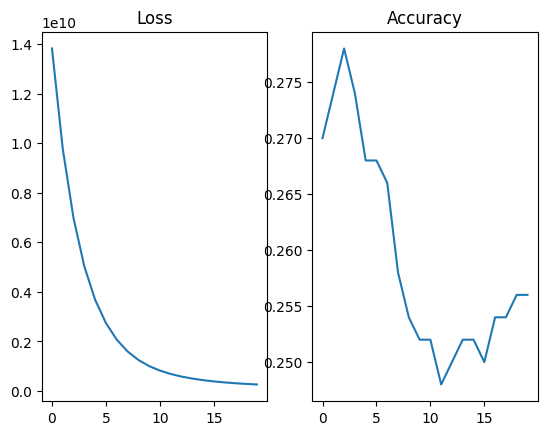

In [65]:
pca_comp = 40
nbor = 10

params = OrderedDict(
# Source
src = [src],
test_src = [src],
test_true_ngh = [src_nearest_inners],
test_fspca_num = [pca_comp],
test_nbor = [nbor],
# Basis Params
num_neighbors = [nbor], # How many neighbors training
num_components = [pca_comp], # How many FSPCA components training
# Data Params
batch_size = [None],
# Model Params
num_templates_init = [20],
Z_init = [None],
# Optimizer Params
lr = [0.2],
momentum = [0.1],
steps = [20],
)

train_model(params, comment = "")
   

In [5]:
m.end_run()

## Results


In [ ]:
#torch.save(Z_hist,r'saves/second run/Z_hist.pt')
#print(len(W_hist))
#print(len(Z_hist))
#print(num_components*num_templates)
#mainZ = Z_hist[9]
#plt.plot(W_hist)
#W_hist

Templates as Images


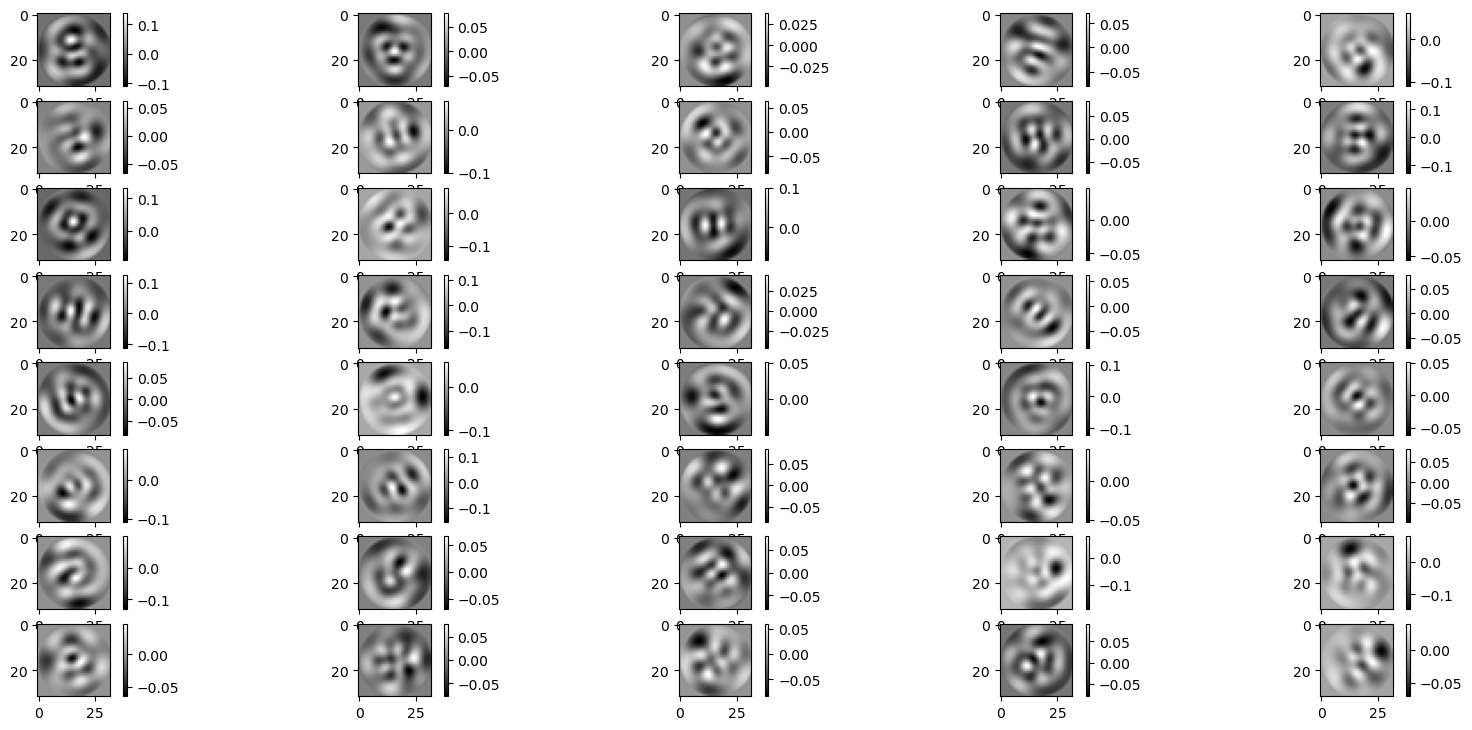

In [31]:
pre_complex = Z.data.numpy()
pre_real = basis_computer.basis.to_real(pre_complex)
after_eval = basis_computer.basis.evaluate_to_image_basis(pre_real).asnumpy()
im = Image(after_eval)
im.show()

"Denoised" Original Images


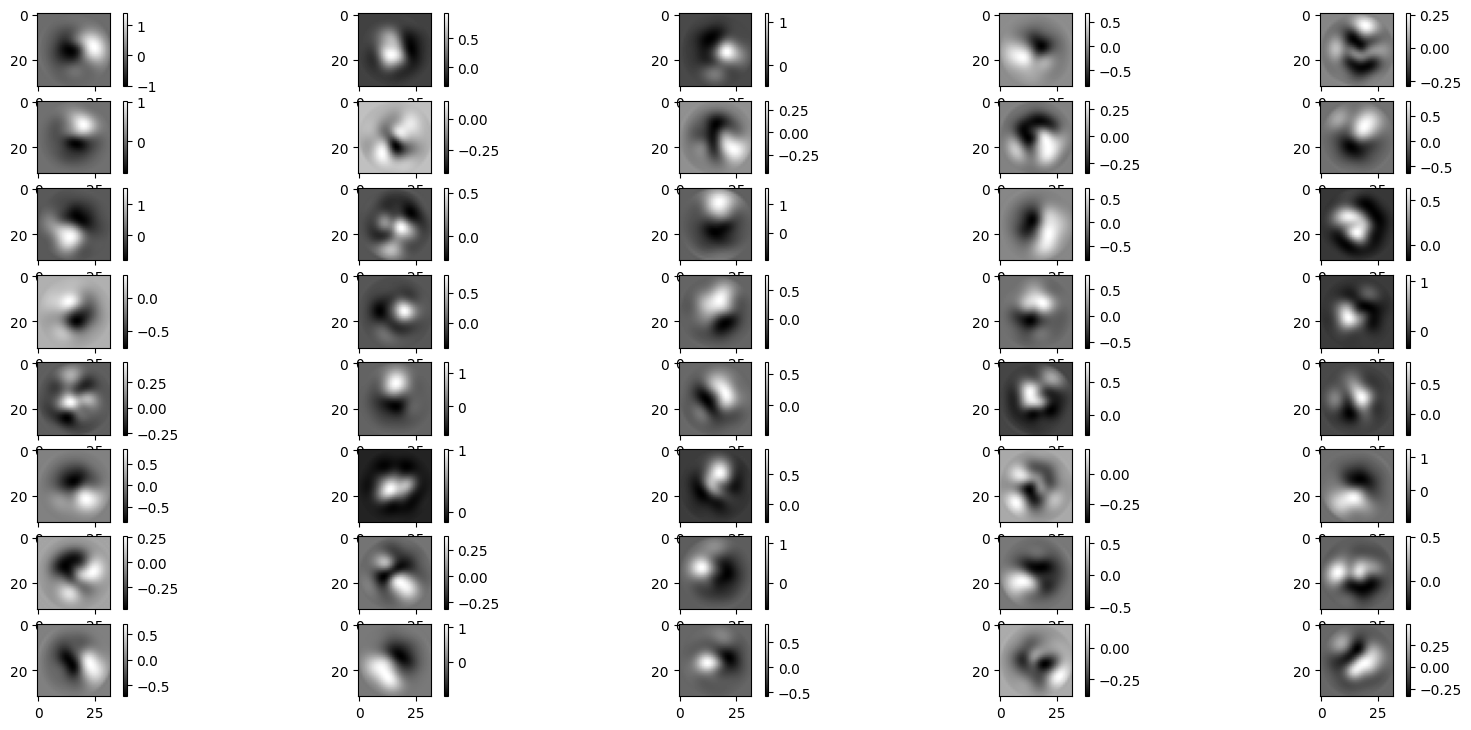

In [ ]:
after_pca_images_numpy = basis.evaluate_to_image_basis(basis.spca_coef).asnumpy()
after_pca_images = Image(after_pca_images_numpy[indices_perm])
after_pca_images.show()

Original Images


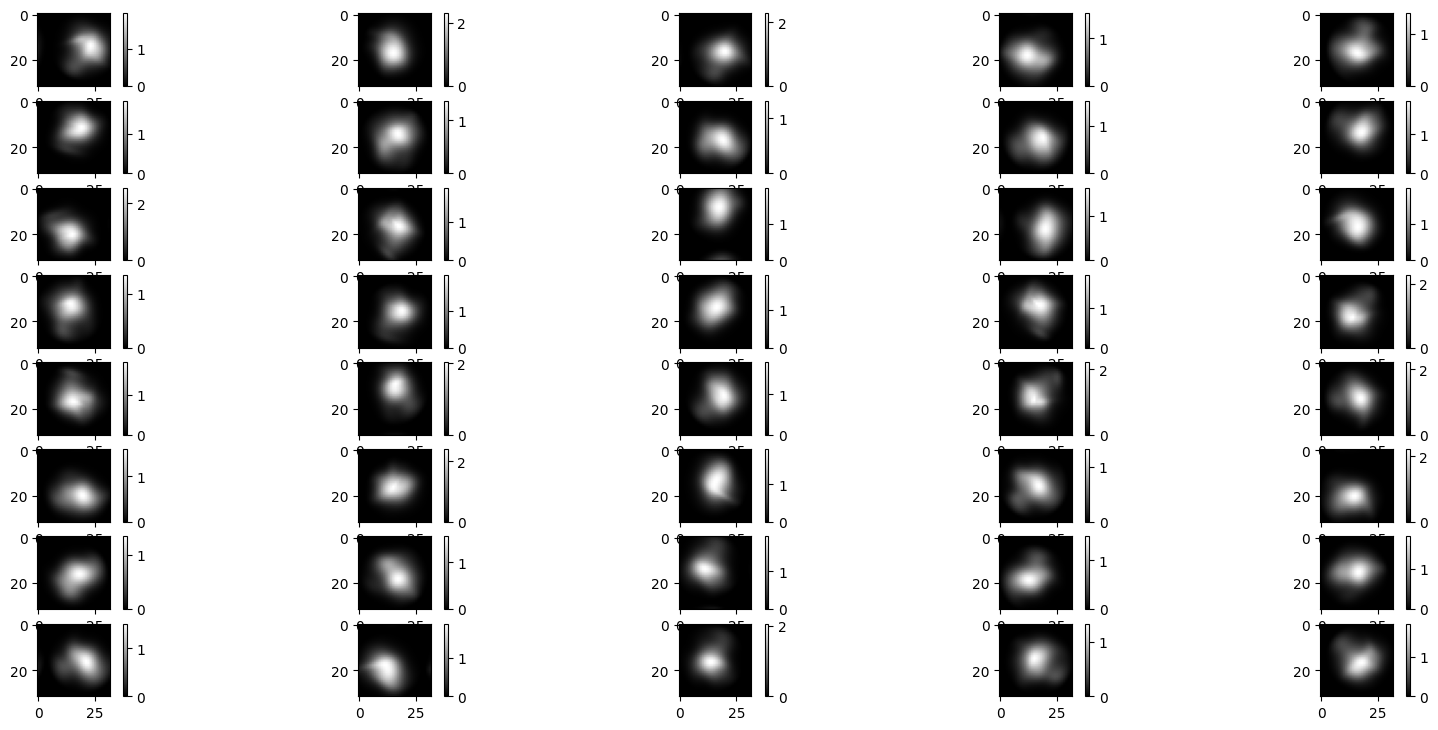

In [ ]:
src.images[indices_perm].show()

## Assessment


In [ ]:
# Assess Performance
#%load_ext line_profiler
#%lprun -f max_filter_bank_torch max_filter_bank_torch(coefs_with_refl[0],Z, fixed_ang_indices, k_max, padding = 400)

In [23]:
#srcTest, noisy_srcTest, trueNgh = gaussian_2D_mix(L = 64)
#Z_images = torch.load(f='runs/Mar26_22-08-14_yousef/Z_images.pt').astype(np.float64)
#assessment_dict = neighbor_assessment(src = noisy_srcTest, trueNgh = trueNgh,
#    trained_templates = Z_images,
#    num_select_templates = 40,
#    fspca_components = 40,
#    bispectrum_components = 40,
#    n_nbor = 10
#)

#clear_output()

In [24]:
#print(assessment_dict['Bispectrum'][0])
#print(assessment_dict['Trained_Templates'][0])
#print(assessment_dict['Select_Source'][0])


0.79287109375
0.848828125
0.961279296875


2023-04-11 10:49:20,996 INFO [aspire.volume.volume] map_data/emd_14930.map.gz with dtype float32 loaded as <class 'numpy.float64'>
2023-04-11 10:49:25,628 INFO [aspire.source.image] Creating Simulation with 10000 images.
2023-04-11 10:49:25,676 INFO [aspire.source.image] Perform phase flip on source object
2023-04-11 10:49:25,677 INFO [aspire.source.image] Adding Phase Flip Xform to end of generation pipeline


100%|███████████████████████████████████████████| 20/20 [01:19<00:00,  3.96s/it]

2023-04-11 10:50:44,975 INFO [aspire.source.image] Whitening source object
2023-04-11 10:50:44,976 INFO [aspire.source.image] Transforming all CTF Filters into Multiplicative Filters
2023-04-11 10:50:44,977 INFO [aspire.source.image] Adding Whitening Filter Xform to end of generation pipeline


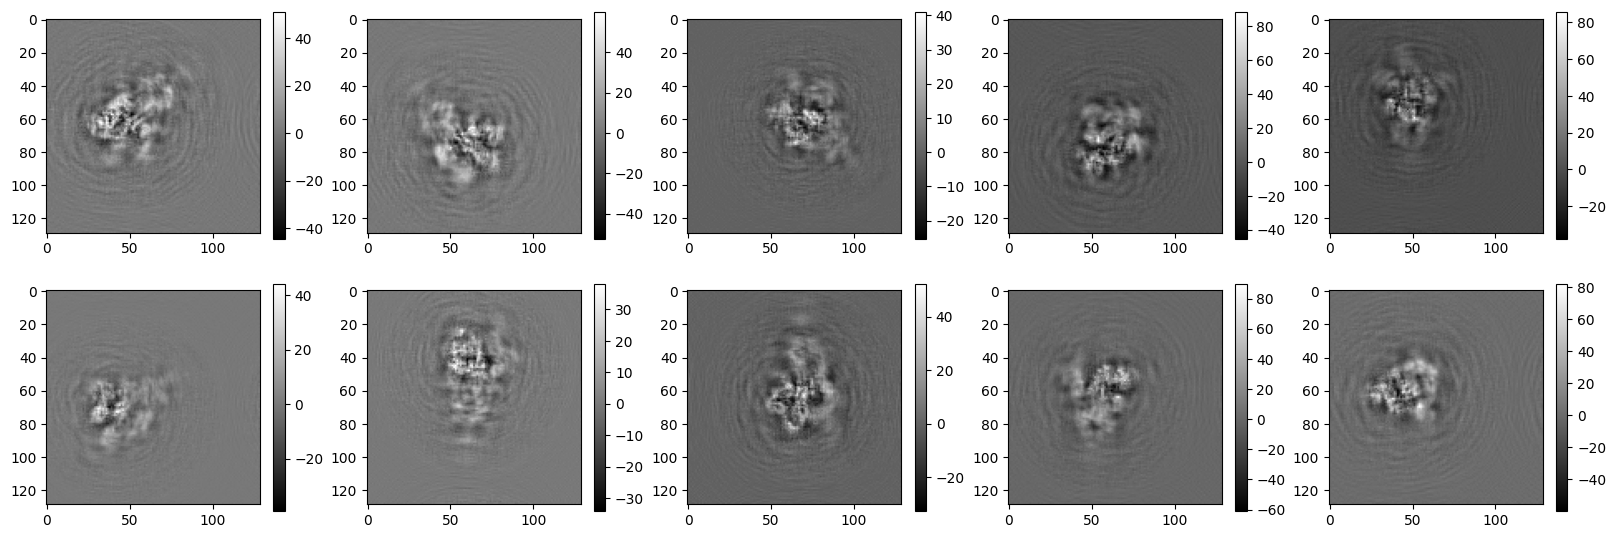

In [117]:
# For each source
# snr loop, templates loop get 2d dataframe for each source
# bi dataframe
# Then, plot bi as straight lines and rest as function of templates

# pixels 129, images = 10000, neighbors 50, cutoff 0.05

src = projection_src(map_path = "map_data/emd_14930.map.gz", sim = "assessment", no_noise = True)
power_clean = src.clean_images[:].norm() ** 2 / src.clean_images[:].size
src_rot_vecs = BasisComputer.rotation_vectors(src)

In [121]:
num_ngh = 50
snr_list = [1/50, 1/100,1/150]
num_template_list = [300, 400, 500]

max_filter_result = np.zeros((len(snr_list),len(num_template_list)))
bi_result = np.zeros(len(snr_list))
for snr_index, snr in enumerate(snr_list):

    noise_variance = power_clean/snr
    src.noise_adder = make_noise_adder(src, power_clean/snr)
    pca_basis = FSPCABasis(src, components = 400, batch_size = 512)

    estNghBi = bi_assessment(src, None, bispectrum_components = 300, fspca_components = None, n_nbor = num_ngh, pca_basis = pca_basis,
                             get_classes_only = True)
    biperc = percentage_correct_rot_vecs(estNghBi, src_rot_vecs, inner_cutoff = 0.95)[0]
    bi_result[snr_index] = biperc
    clear_output()
    print("bi result " + str(bi_result))
    for temp_index, num_temp in enumerate(num_template_list):
        estNgh = max_select_assessment(src, None, num_select_templates = num_temp, fspca_components = None, n_nbor = num_ngh, pca_basis = pca_basis,
                             get_classes_only = True)
        maxperc = percentage_correct_rot_vecs(estNgh, src_rot_vecs, inner_cutoff = 0.95)[0]
        max_filter_result[snr_index, temp_index] = maxperc
        clear_output()
        print("bi result " + str(bi_result))
        print("max result " + str(max_filter_result))


bi result [[0.051074 0.052852 0.054004]
 [0.050746 0.052806 0.054706]]
max result [[0.051074 0.052852 0.054004]
 [0.050746 0.052806 0.054706]]


In [122]:
max_filter_result

array([[0.051074, 0.052852, 0.054004],
       [0.050746, 0.052806, 0.054706]])

In [123]:
bi_result

array([0.044866, 0.044948])

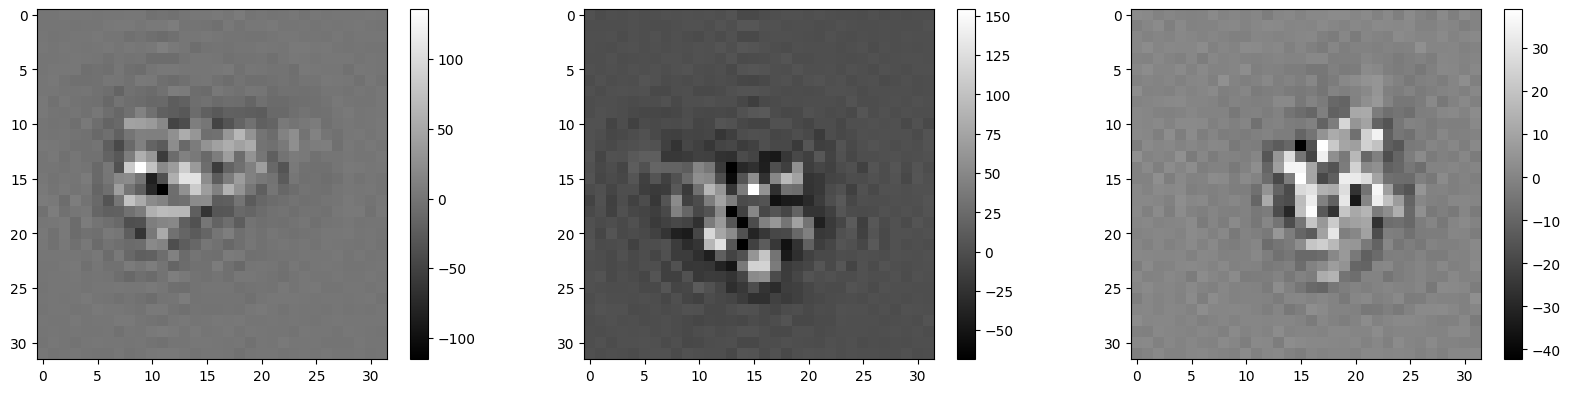

In [98]:
src.noise_adder = make_noise_adder(src, power_clean/snr)
src.images[0:3].show()

## Notes
- Edit loss?
- Make assessment into a class (two notions of assessment)